---
title: Non-Hierarchical Logistic and Bayesian Binomial Models
subject: Methods
subtitle: Facility-level SSI risk modeling without partial pooling
exports: 
  - format: pdf
    template: curvenote
    # template: arxiv_two_column # requires abstract
  # - format: pdf+tex
keywords: [logistic regression, Bayesian binomial model, surgical site infection, hospital performance, facility-level risk, statistical modeling, healthcare quality]
---

In [ ]:
library(dplyr)
library(ggplot2)
library(plotly)
library(kableExtra)
library(IRdisplay)
library(rjags)

# Load data
dat <- read.csv(
  "data/ca_ssi_adult_odp_2024.csv",
  header = TRUE,
  fileEncoding = "latin1"
)

# Restrict to colon procedures
colon_fac <- dat |>
  filter(Operative_Procedure == "Colon surgery") |>
  select(
    County,
    Facility_ID,
    Facility_Name,
    Hospital_Category_RiskAdjustment,
    Facility_Type,
    Procedure_Count,
    Infections_Reported,
    Infections_Predicted,
    SIR,
    SIR_CI_95_Upper_Limit,
    SIR_CI_95_Lower_Limit,
    Comparison,
    Notes
  ) |>
  mutate(observed_rate_fac = Infections_Reported/Procedure_Count)

# Use ACH only and drop pediatric facilities
colon_fac_ach <- colon_fac |>
  filter(Hospital_Category_RiskAdjustment == "Acute Care Hospital",
         Facility_Type != "Pediatric") |>
  mutate(County_numfactor = as.numeric(factor(County)),
         Facility_ID_numfactor = as.numeric(factor(Facility_ID)),
         Facility_Type = factor(Facility_Type),
         No_Infections = Procedure_Count - Infections_Reported) |>
  select(-Hospital_Category_RiskAdjustment) |>
  # pooled county-level counts and rates
  group_by(County) |>
    mutate(
      county_procedures = sum(Procedure_Count, na.rm = TRUE),
      county_infections = sum(Infections_Reported, na.rm = TRUE),
      observed_rate_county = county_infections / county_procedures
    ) |>
  ungroup()

# State mean SSI rate
state_mean <- sum(colon_fac_ach$Infections_Reported) / 
  sum(colon_fac_ach$Procedure_Count)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



## Binomial logistic regression

Below, a standard logistic regression model is fit to the data. `Community, <125 Beds` facilities are used for the reference group.

In [3]:
lr_fit <- glm(cbind(Infections_Reported, No_Infections) ~ Facility_Type,
              data = colon_fac_ach, family = binomial)

summary(lr_fit)


Call:
glm(formula = cbind(Infections_Reported, No_Infections) ~ Facility_Type, 
    family = binomial, data = colon_fac_ach)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -4.3979     0.2012 -21.856  < 2e-16 ***
Facility_TypeCommunity, >250 Beds      0.6069     0.2194   2.767  0.00566 ** 
Facility_TypeCommunity, 125-250 Beds   0.4526     0.2326   1.946  0.05165 .  
Facility_TypeMajor Teaching            0.6122     0.2076   2.949  0.00318 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 495.24  on 287  degrees of freedom
Residual deviance: 483.68  on 284  degrees of freedom
AIC: 977.75

Number of Fisher Scoring iterations: 5


The standard logistic regression with facility type as the only factor with 4 levels produces only 4 predicted probabilities, which does not adequately explain the large variation observed across individual facilities. This model treats all facilities of the same type identically, ignoring facility volume and county-level effects.

## Bayesian binomial model

The Bayesian binomial model is fit next. Weakly informative $\text{N}(0, 5^2)$ priors are used for the parameters.

$$
\begin{aligned}
y_i \mid \phi_i &\sim \text{Binomial}(n_i, \phi_i), \quad i = 1, \dots, 288 \\
\text{logit}(\phi_i) &= \beta_0 + \beta_1 \cdot \text{beds}_{125\text{-}250,i} + 
                        \beta_2 \cdot \text{beds}_{>250,i} + 
                        \beta_3 \cdot \text{major\_teach}_i \\
\beta_j &\sim \text{Normal}(0, 5^2), \quad j = 0,1,2,3
\end{aligned}
$$

In [4]:
# Non-hierarchical binomial Bayesian model
# Facility type reference level: Community, <125 Beds
data_jags_nh <- list(
  y = colon_fac_ach$Infections_Reported,
  n = colon_fac_ach$Procedure_Count,
  beds_125to250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, 125-250 Beds'),
  beds_gt250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, >250 Beds'),
  major_teach = as.numeric(colon_fac_ach$Facility_Type == 'Major Teaching'),
  N = nrow(colon_fac_ach),
  J = 3  # number of predictors
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 288
   Unobserved stochastic nodes: 4
   Total graph size: 1466

Initializing model



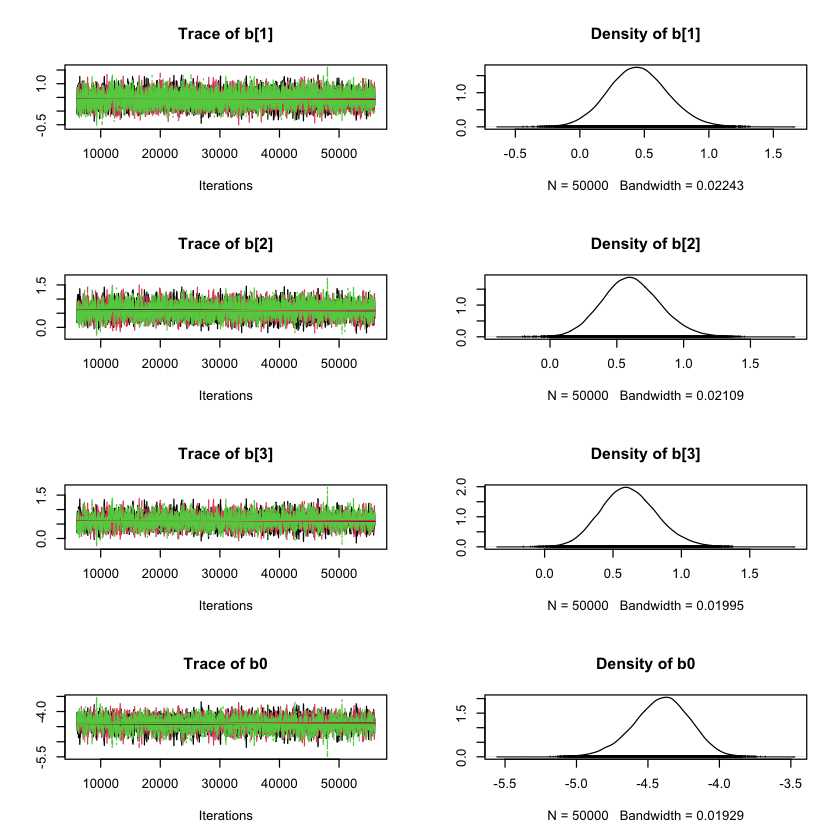

In [5]:
set.seed(530)

mod_string_nh <- " model {
  # likelihood
  for (i in 1:N) {
    y[i] ~ dbin(p[i], n[i])
    logit(p[i]) <- b0 + b[1]*beds_125to250[i] + b[2]*beds_gt250[i] + 
                        b[3]*major_teach[i]
  }

  # priors
  b0 ~ dnorm(0, 1.0/5^2)
  for (j in 1:J) {
    b[j] ~ dnorm(0.0, 1.0/5^2)  # weakly informative priors (sd ~5)
  }
} "

mod_nh <- jags.model(textConnection(mod_string_nh),
                     data = data_jags_nh,
                     n.chains = 3)

update(mod_nh, 5000)  # burn-in

params_nh <- c("b0", "b")

mod_sim_nh <- coda.samples(mod_nh, variable.names = params_nh, n.iter = 5e4)

plot(mod_sim_nh)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1       1.01
b[2]          1       1.01
b[3]          1       1.02
b0            1       1.02

Multivariate psrf

1

,b[1],b[2],b[3],b0
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000
Lag 1,0.8019610,0.8741676,0.9523847,0.9682274
Lag 5,0.6737311,0.7601096,0.8544624,0.8724838
Lag 10,0.5935015,0.6691569,0.7527237,0.7681594
Lag 50,0.2241113,0.2527751,0.2840573,0.2904574


b[1]     b[2]     b[3]       b0 
2522.344 2246.487 1954.004 1956.506

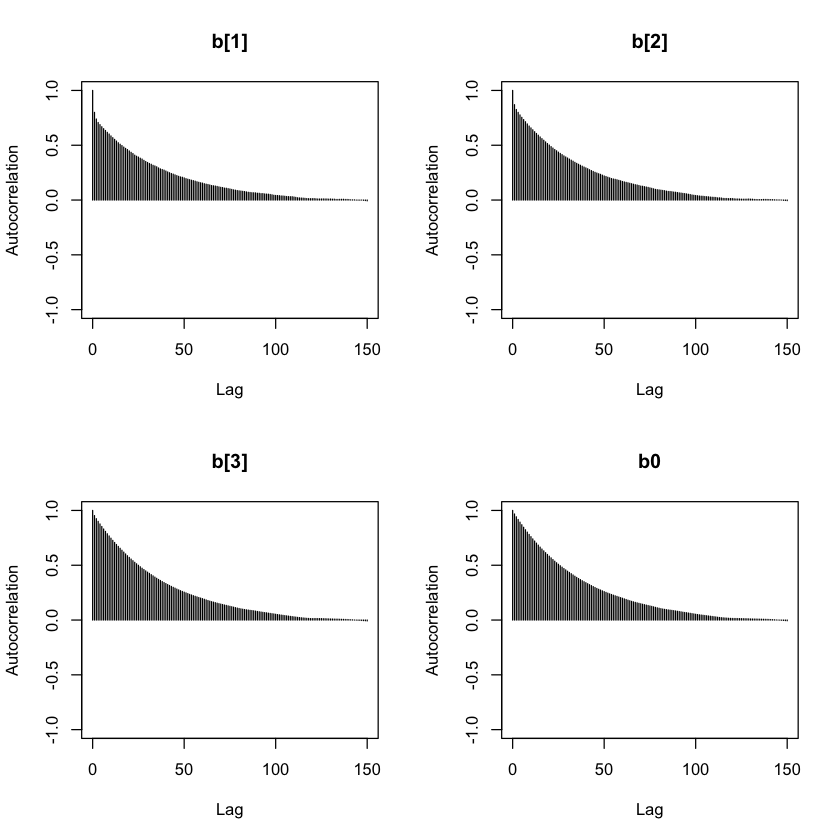

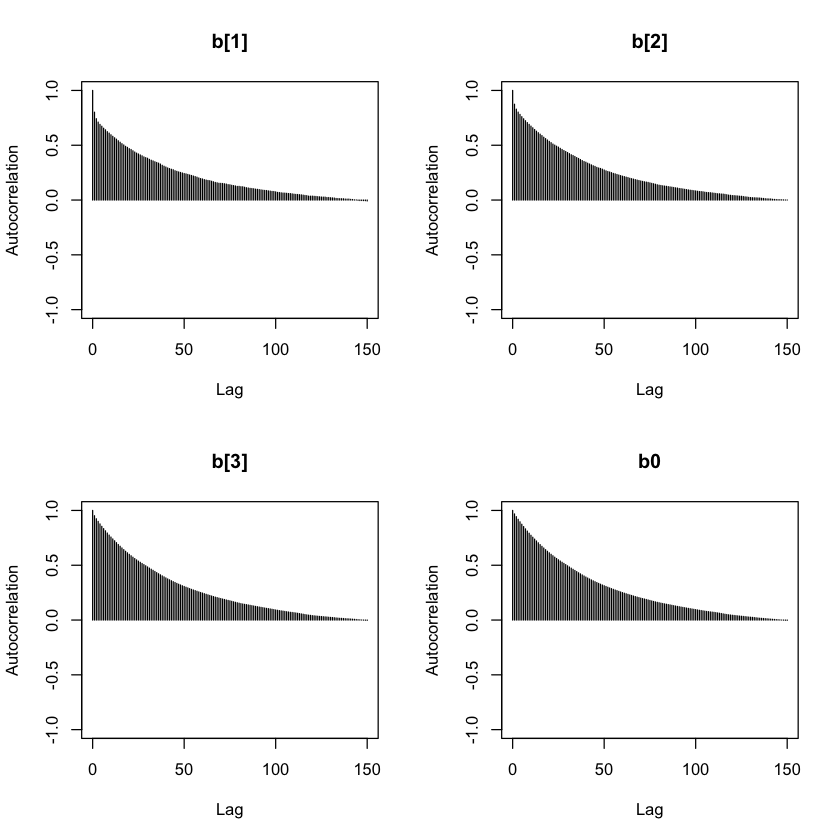

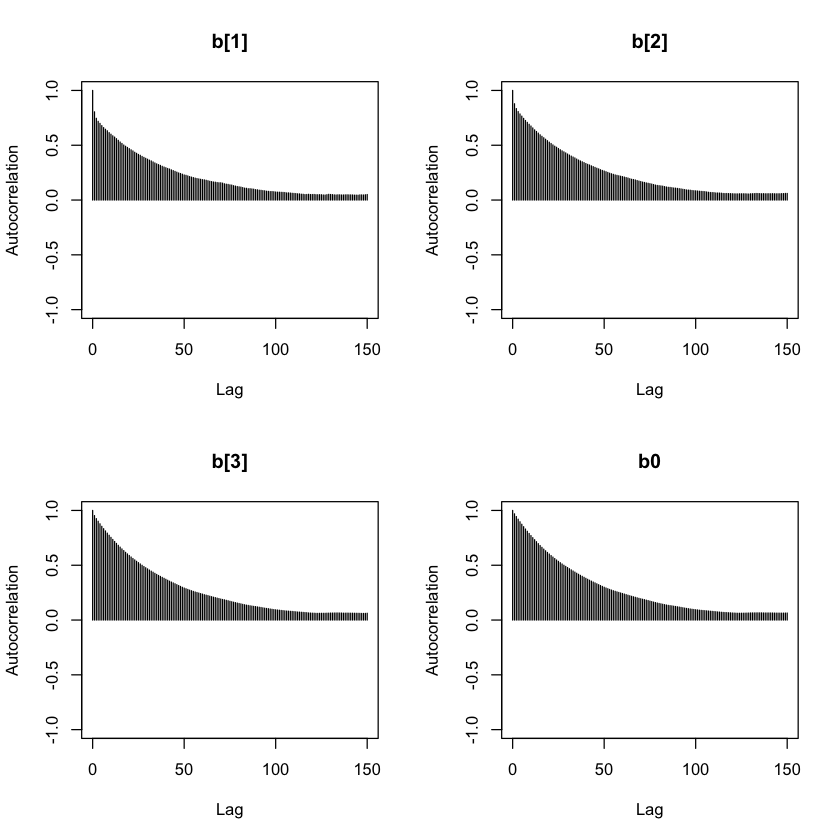

In [7]:
gelman.diag(mod_sim_nh)

autocorr.diag(mod_sim_nh)

effectiveSize(mod_sim_nh)

autocorr.plot(mod_sim_nh, lag.max = 150)

In [8]:
raftery.diag(mod_sim_nh)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 32       38616  3746         10.3      
 b[2] 45       54693  3746         14.6      
 b[3] 60       74260  3746         19.8      
 b0   110      110920 3746         29.6      


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 35       38276  3746         10.2      
 b[2] 48       54960  3746         14.7      
 b[3] 56       55120  3746         14.7      
 b0   112      125160 3746         33.4      


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin) 

In [10]:
(dic_nh <- dic.samples(mod_nh, n.iter = 1e3))

Mean deviance:  973.5 
penalty 3.544 
Penalized deviance: 977.1 

In [11]:
summary(mod_sim_nh)


Iterations = 6001:56000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD  Naive SE Time-series SE
b[1]  0.4520 0.2300 0.0005938       0.004590
b[2]  0.6088 0.2173 0.0005610       0.004585
b[3]  0.6165 0.2051 0.0005297       0.004643
b0   -4.4038 0.1988 0.0005134       0.004492

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
b[1]  0.01351  0.2955  0.4471  0.6031  0.9178
b[2]  0.19962  0.4613  0.6024  0.7504  1.0548
b[3]  0.23666  0.4761  0.6089  0.7496  1.0420
b0   -4.81599 -4.5322 -4.3958 -4.2677 -4.0369
